I want to build a machine learning model that can analyze Java methods and suggest potential refactoring opportunities based on features extracted from the code. Specifically, ywhich is focusing on Extract Method refactoring, which involves identifying large, complex methods that could be broken down into smaller, more manageable methods.

### Preprocess the Data

#### Load the Data:

Already have the CSV with features. Loading this data into a Pandas DataFrame for analysis.

In [30]:
import pandas as pd

clean_lines = []
with open('../features_output.csv', 'r') as f:
    header = f.readline()
    clean_lines.append(header.strip())
    
    for line in f:
        parts = line.strip().split(',')
        if len(parts) > 10:
            fixed_line = ','.join(parts[:9]) + ',"' + ','.join(parts[9:]) + '"'
            clean_lines.append(fixed_line)
        else:
            clean_lines.append(line.strip())

with open('../features_output_cleaned.csv', 'w') as f:
    for line in clean_lines:
        f.write(line + '\n')

# Now read the cleaned version
import pandas as pd
data = pd.read_csv('../features_output_cleaned.csv')




The final column contained multiple unquoted commas, which caused certain rows to exceed the expected number of fields. To resolve this, the file was cleaned by identifying and correcting rows with more than 10 fields—presumably due to the unquoted full_name column—so that it can be properly loaded using pandas.

In [31]:
data.head()


,method_name,num_params,line_number,num_calls,num_locals,num_returns,num_invocations,body_size,num_control_structures,full_name
0,<init>,1,Some(82),0,0,0,0,7,0,org.apache.aries.samples.ariestrader.entities....
1,<init>,6,Some(85),5,0,0,5,32,0,org.apache.aries.samples.ariestrader.entities....
2,<init>,6,Some(94),5,0,0,5,32,0,org.apache.aries.samples.ariestrader.entities....
3,getRandomInstance,0,Some(103),15,3,1,15,45,0,org.apache.aries.samples.ariestrader.entities....
4,toString,1,Some(112),14,0,1,14,32,0,org.apache.aries.samples.ariestrader.entities....


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33593 entries, 0 to 33592
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   method_name             33593 non-null  object
 1   num_params              33593 non-null  int64 
 2   line_number             18197 non-null  object
 3   num_calls               33593 non-null  int64 
 4   num_locals              33593 non-null  int64 
 5   num_returns             33593 non-null  int64 
 6   num_invocations         33593 non-null  int64 
 7   body_size               33593 non-null  int64 
 8   num_control_structures  33593 non-null  int64 
 9   full_name               33593 non-null  object
dtypes: int64(7), object(3)
memory usage: 2.6+ MB


We can observe that Line number is the most missing filed, it is an important feature but a lot of data will be lost so I would rather replacec it with its mean value.

##### Possible reasons:
- Some methods might not be directly associated with a line number, such as synthetic methods, lambdas, or default constructors.

- The data extraction process (like a static analyzer or parser) might have skipped or failed to retrieve line numbers for certain entries.

- The missing entries could correspond to library-generated code or auto-generated artifacts that don’t have precise line mappings.

In [33]:
missing_ln = data[data['line_number'].isnull()]
print(f"Missing line numbers: {len(missing_ln)}")


Missing line numbers: 15396


In [34]:
missing_method_counts = missing_ln['method_name'].value_counts().head(10)
print(missing_method_counts)


method_name
<init>          1250
add              134
assertEquals     122
get              119
getName          104
assertTrue        99
close             78
toString          76
getClass          70
fail              68
Name: count, dtype: int64


<init> (constructors):

Being the most common (1250), it could be that constructor methods were parsed differently or lacked precise location data in your source extraction tool.

assert* and fail methods:

These are commonly used in unit testing, which might suggest test classes or test-related methods aren't tracked the same way.

Simple getters/setters (get, getName, toString, getClass):

These methods are usually short and potentially auto-generated or placed in ways that are skipped by parsers.

add, close:

These might show up across a wide range of classes and can also be overridden frequently.

In [35]:
missing_ln[missing_ln['method_name'] == '<init>']['full_name'].value_counts().head(10)


full_name
org.apache.aries.samples.ariestrader.entities.HoldingDataBeanImpl.<init>:<unresolvedSignature>(5)              1
com.badlogic.gdx.graphics.FPSLogger.<init>:void()                                                              1
java.lang.String.<init>:void(byte[],int,int,java.nio.charset.Charset)                                          1
java.util.zip.GZIPInputStream.<init>:void(java.io.InputStream)                                                 1
java.lang.String.<init>:void(byte[],java.nio.charset.Charset)                                                  1
java.util.zip.GZIPOutputStream.<init>:void(java.io.OutputStream)                                               1
org.elasticsearch.common.Base64.decodeToObject.java.io.ObjectInputStream$0.<init>:void(java.io.InputStream)    1
java.io.FilterOutputStream.<init>:void(java.io.OutputStream)                                                   1
java.io.FilterInputStream.<init>:void(java.io.InputStream)                            

 Key Insights:
Library/Framework Constructors
These might be imported or referenced in your code but not actually defined there — which could explain why line numbers are missing. The parser likely skips external class definitions.

Unresolved Signatures
Entries like :<unresolvedSignature>(...) suggest some part of the parsing failed to properly resolve the method body or its metadata. Could be due to:

Missing debug symbols or source

Bytecode-level analysis hitting a limitation

Obfuscated or precompiled class files

Spread Across Domains
Since both custom application code and Java core libraries are affected, your tool might treat external dependencies differently than your own project source.

In [36]:
def is_external(full_name):
    return full_name.startswith("java.") or full_name.startswith("javax.") or \
           full_name.startswith("org.apache.") or full_name.startswith("org.elasticsearch.") or \
           full_name.startswith("com.badlogic.")

missing_ln['is_external'] = missing_ln['full_name'].apply(is_external)
missing_ln['is_external'].value_counts()

/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2293676064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ln['is_external'] = missing_ln['full_name'].apply(is_external)


is_external
False    10515
True      4881
Name: count, dtype: int64

Nice! So from the 15,396 methods with missing line numbers, about:

10,515 (~68.3%) are internal (your own project code or dependencies within the project),

4,881 (~31.7%) are external (like Java standard libraries or major frameworks).

🧠 Interpretation:
This tells us that line number absence isn’t just due to external dependencies. our own codebase also has a significant number of methods without line numbers.

In [37]:
data['line_number'].dropna().describe()


count        18197
unique        2394
top       Some(48)
freq            81
Name: line_number, dtype: object

In [38]:
some_48_rows = data[data['line_number'] == "Some(48)"]
some_48_rows.head()  # Display the first few rows

,method_name,num_params,line_number,num_calls,num_locals,num_returns,num_invocations,body_size,num_control_structures,full_name
512,equals,2,Some(48),11,1,3,11,54,4,org.apache.lucene.util.automaton.fst.PairOutpu...
1695,<clinit>,0,Some(48),5,0,0,5,15,0,uci.uml.ui.PropPanelInterface.<clinit>:void()
1697,analyseCode,4,Some(48),3,0,1,3,22,0,org.eclipse.jdt.internal.compiler.ast.CastExpr...
1807,getCategoryId,1,Some(48),0,0,0,0,8,0,org.eclipse.ui.commands.ICommand.getCategoryId...
2625,<clinit>,0,Some(48),12,0,0,12,68,0,org.columba.mail.gui.charset.CharacterEncoding...


In [39]:

missing_ln_rows = data[data['line_number'].isna()]
missing_ln_rows.head()  # Display the first few rows with missing line numbers

,method_name,num_params,line_number,num_calls,num_locals,num_returns,num_invocations,body_size,num_control_structures,full_name
18197,setAccount,2,NaN,0,0,0,0,7,0,org.apache.aries.samples.ariestrader.entities....
18198,setQuote,2,NaN,0,0,0,0,7,0,org.apache.aries.samples.ariestrader.entities....
18199,<operator>.assignment,2,NaN,0,0,0,0,7,0,<operator>.assignment
18200,<operator>.alloc,4,NaN,0,0,0,0,11,0,<operator>.alloc
18201,<init>,6,NaN,0,0,0,0,15,0,org.apache.aries.samples.ariestrader.entities....


In [40]:
missing_ln_rows['method_name'].value_counts().head(10)  # Most common methods with missing line numbers


method_name
<init>          1250
add              134
assertEquals     122
get              119
getName          104
assertTrue        99
close             78
toString          76
getClass          70
fail              68
Name: count, dtype: int64

 Convert line_number to Numeric:

In [41]:
# Force 'line_number' to string, then extract digits
data['line_number'] = pd.to_numeric(data['line_number'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')


In [42]:
# Replace missing 'line_number' based on method name analysis
def replace_line_numbers(row):
    if pd.isna(row['line_number']):
        if row['method_name'] == '<init>':
            return 1  # assuming constructor is at the first line of the class
        elif row['method_name'] in ['assertEquals', 'assertTrue', 'fail']:
            return 0  # for test methods, use 0 as a placeholder
        elif row['method_name'] in ['get', 'getName', 'getClass']:
            return -2  # for common getter methods, use -2 as a placeholder
        else:
            return -1  # for other missing values, use -1 as a default
    return row['line_number']  # if the value is not missing, keep it unchanged

# Apply the function to replace missing line numbers
data['line_number'] = data.apply(replace_line_numbers, axis=1)

# Check the result
print(data['line_number'].isna().sum()) 

0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33593 entries, 0 to 33592
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   method_name             33593 non-null  object 
 1   num_params              33593 non-null  int64  
 2   line_number             33593 non-null  float64
 3   num_calls               33593 non-null  int64  
 4   num_locals              33593 non-null  int64  
 5   num_returns             33593 non-null  int64  
 6   num_invocations         33593 non-null  int64  
 7   body_size               33593 non-null  int64  
 8   num_control_structures  33593 non-null  int64  
 9   full_name               33593 non-null  object 
dtypes: float64(1), int64(7), object(2)
memory usage: 2.6+ MB


Now we have a perfectlty symmetric data with all the fields available to analyse and I wont depend on line_number so much for init atleast as many of them were missing

In [44]:
data.describe()

,num_params,line_number,num_calls,num_locals,num_returns,num_invocations,body_size,num_control_structures
count,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000
mean,1.873962,270.187003,7.059506,0.669485,0.321109,7.059506,27.603340,0.661745
std,1.811805,574.694470,28.550194,2.748786,1.304512,28.550194,73.258965,3.300859
min,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000
50%,2.000000,52.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000
75%,2.000000,293.000000,4.000000,0.000000,0.000000,4.000000,21.000000,0.000000
max,258.000000,7251.000000,1892.000000,183.000000,132.000000,1892.000000,4194.000000,230.000000


In [45]:
data.head()

,method_name,num_params,line_number,num_calls,num_locals,num_returns,num_invocations,body_size,num_control_structures,full_name
0,<init>,1,82.0,0,0,0,0,7,0,org.apache.aries.samples.ariestrader.entities....
1,<init>,6,85.0,5,0,0,5,32,0,org.apache.aries.samples.ariestrader.entities....
2,<init>,6,94.0,5,0,0,5,32,0,org.apache.aries.samples.ariestrader.entities....
3,getRandomInstance,0,103.0,15,3,1,15,45,0,org.apache.aries.samples.ariestrader.entities....
4,toString,1,112.0,14,0,1,14,32,0,org.apache.aries.samples.ariestrader.entities....


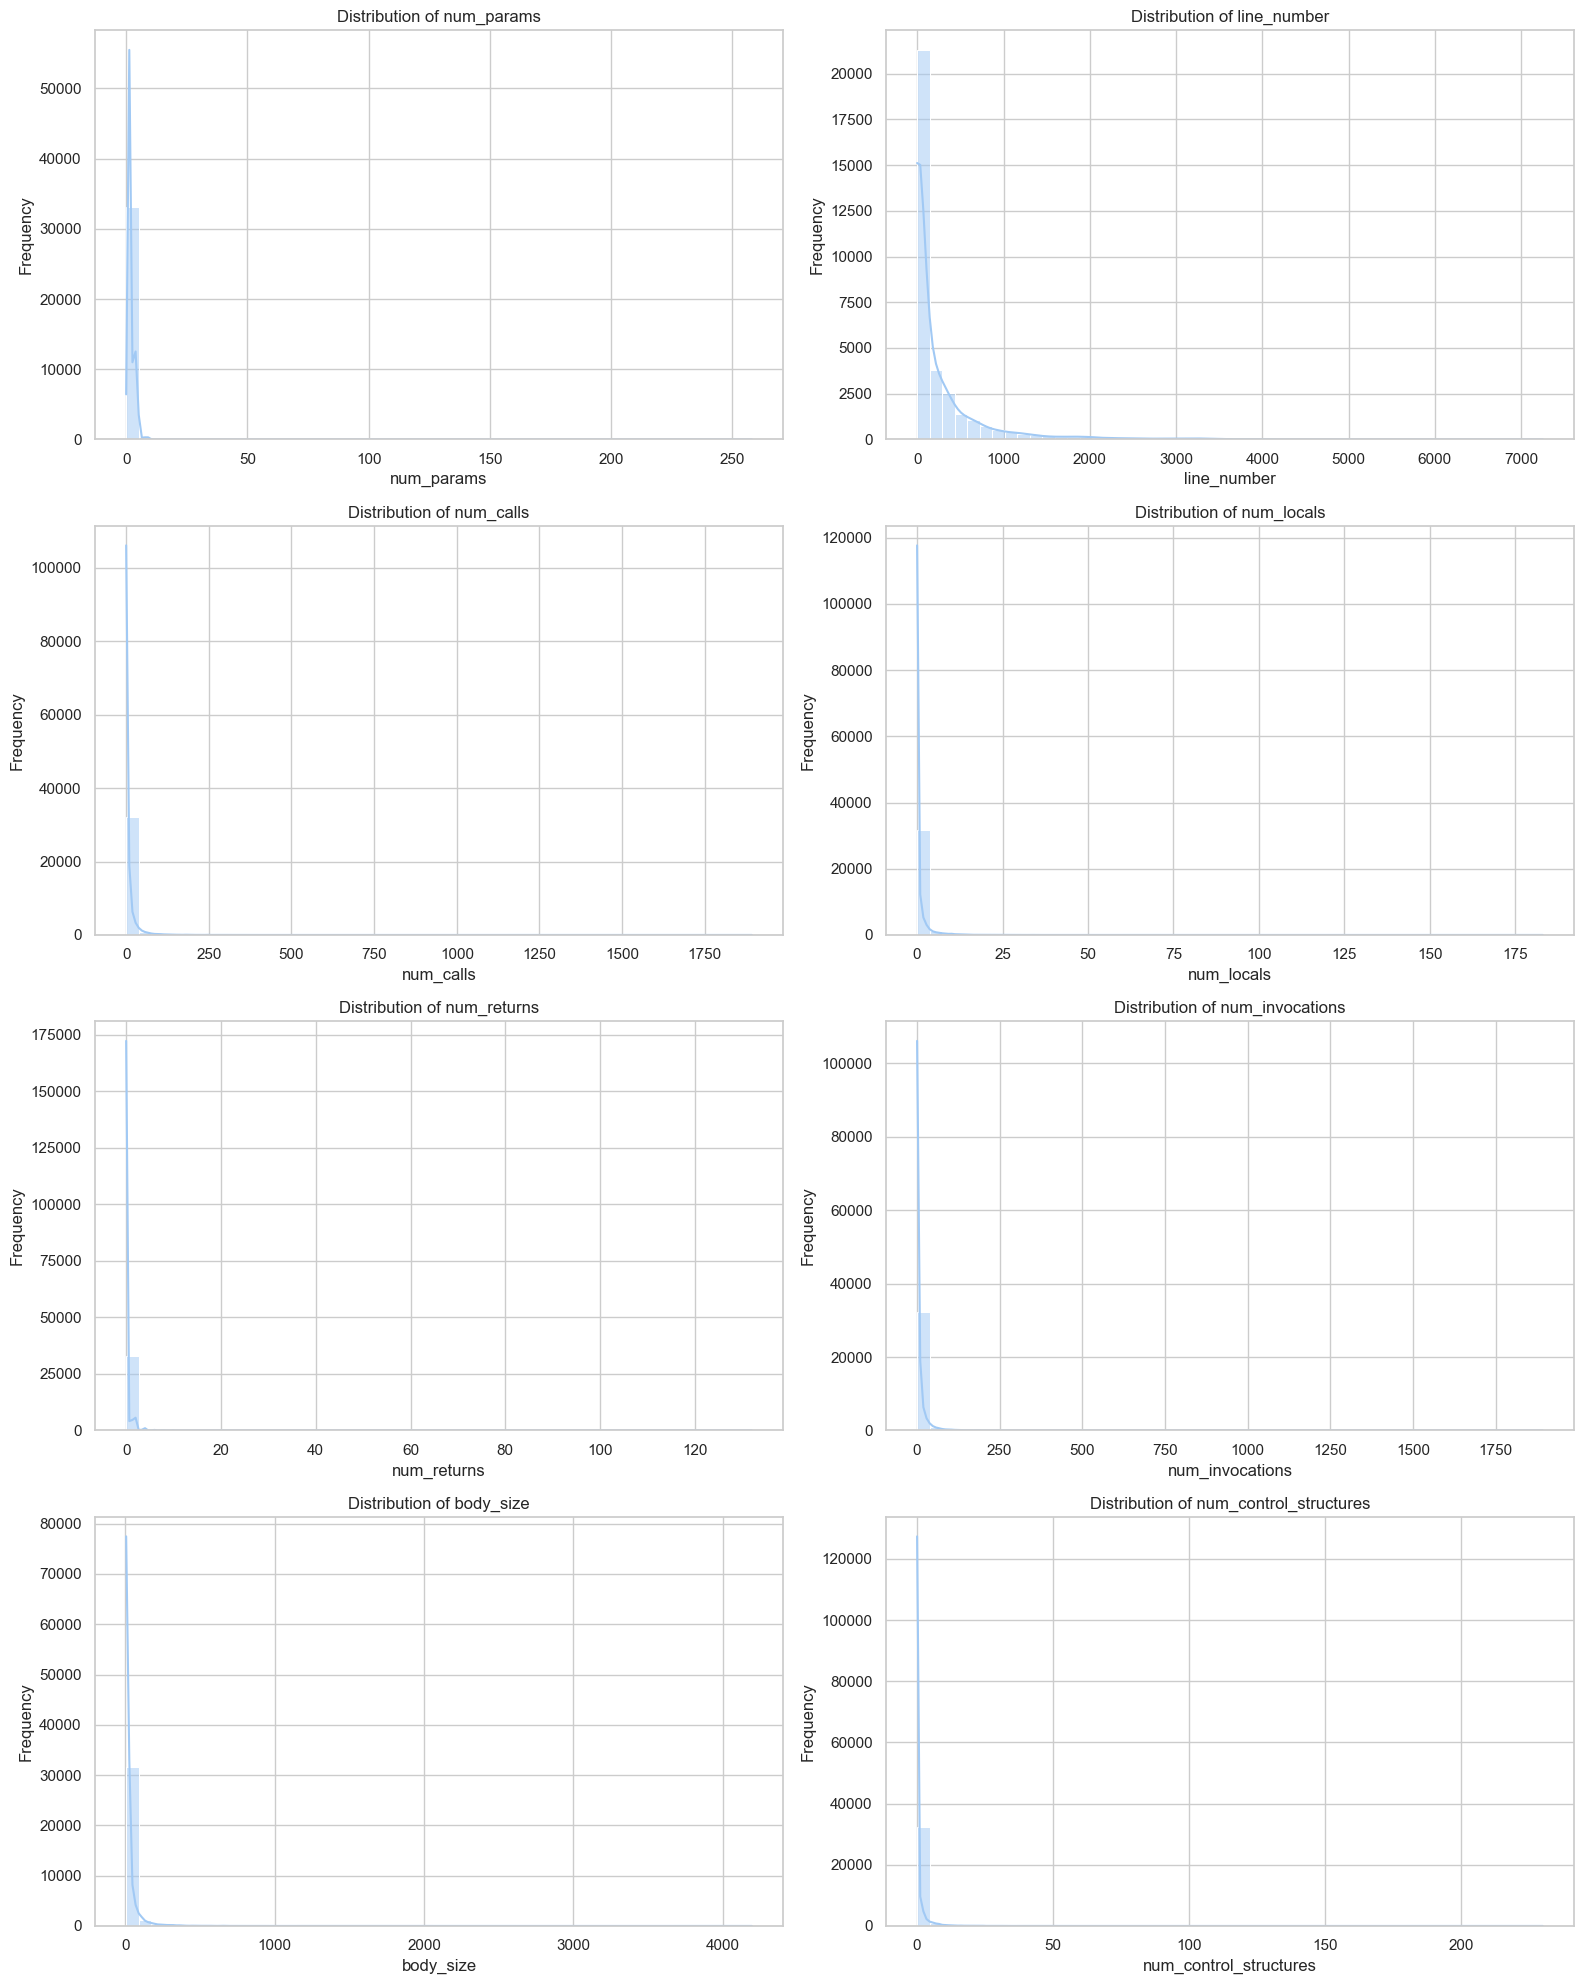

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns
numerical_cols = ['num_params', 'line_number', 'num_calls', 'num_locals', 'num_returns', 'num_invocations', 'body_size', 'num_control_structures']

# Set up the grid
plt.figure(figsize=(16, 20))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [47]:
import numpy as np

# Log-transform the numerical columns to reduce skewness
log_scaled_data = data[numerical_cols].apply(lambda x: np.log1p(x))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


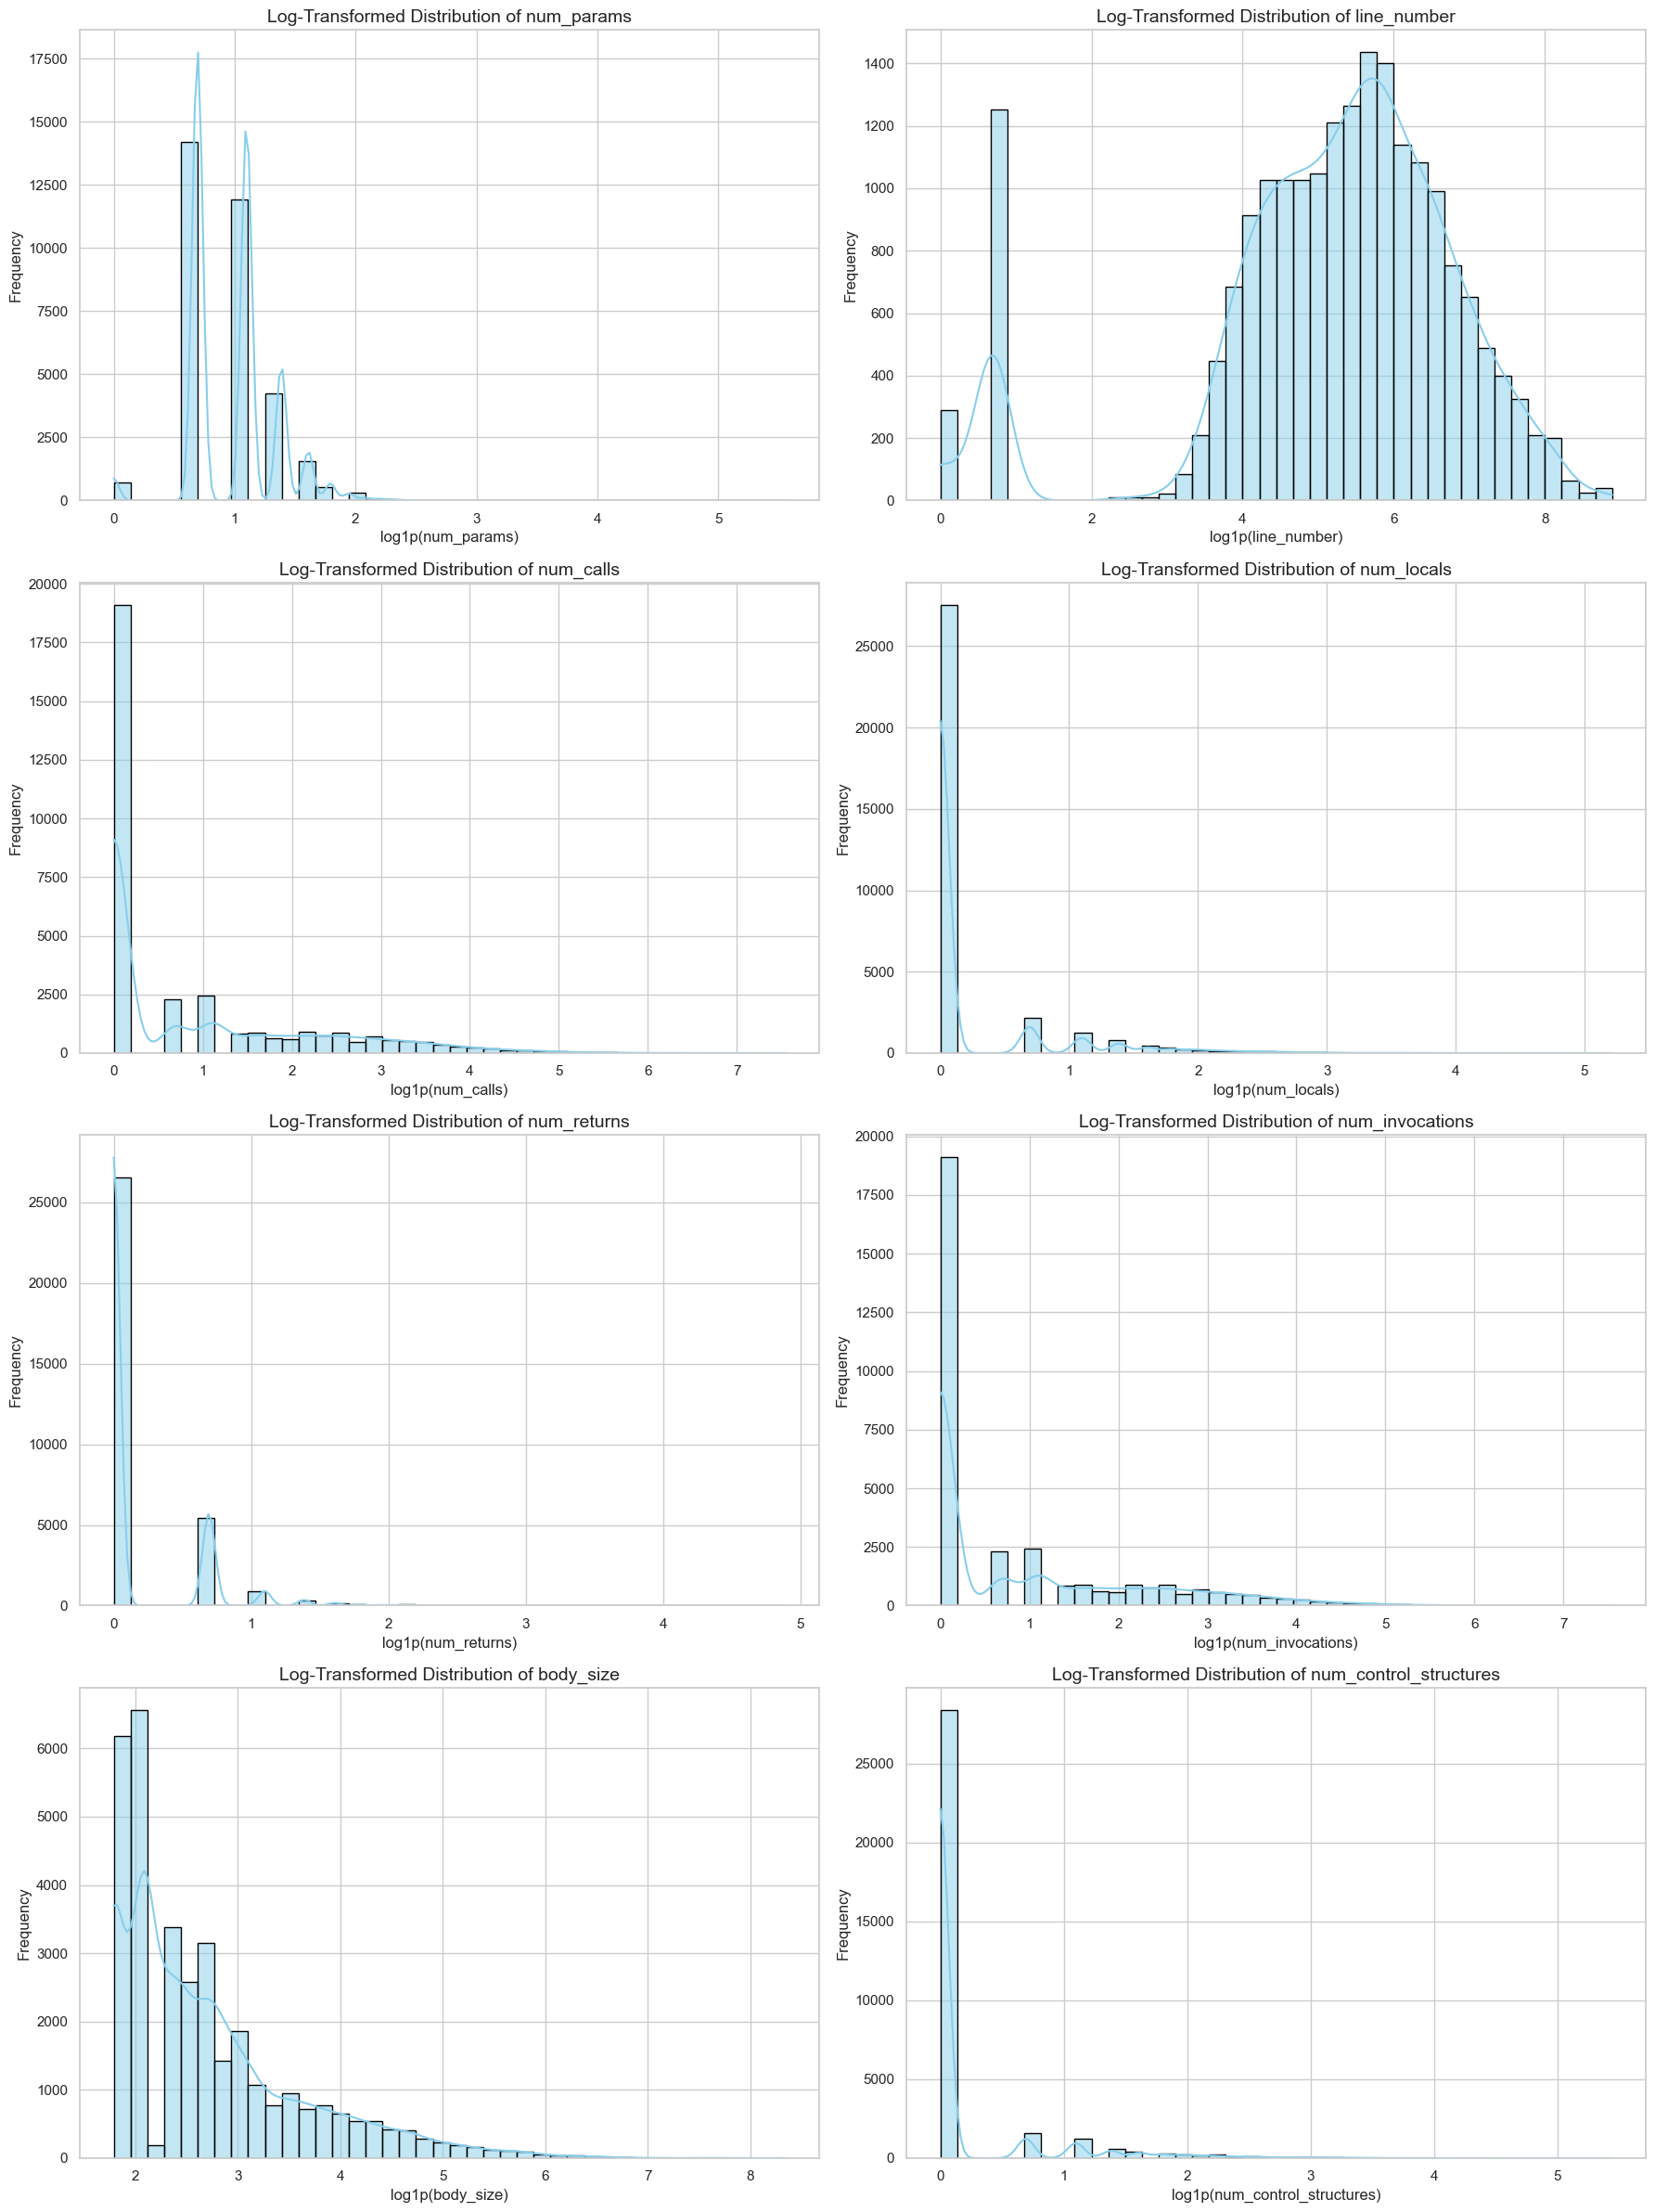

In [48]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(18, 24))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(log_scaled_data[col].dropna(), bins=40, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Log-Transformed Distribution of {col}', fontsize=14)
    plt.xlabel(f'log1p({col})', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()


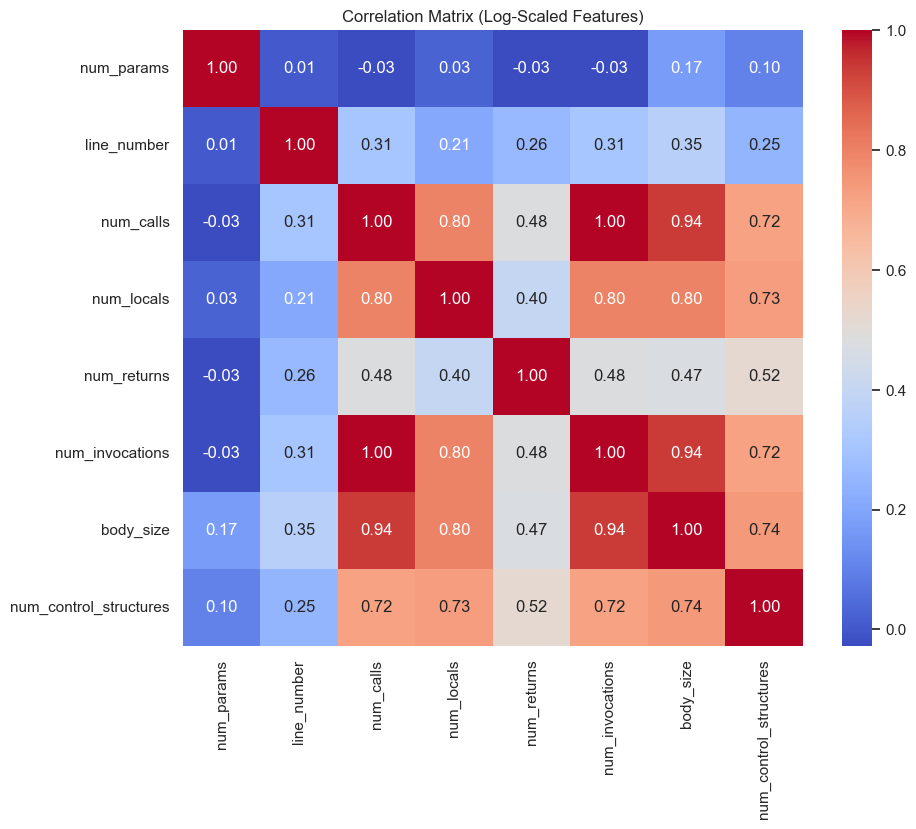

In [49]:
plt.figure(figsize=(10, 8))
corr_matrix = log_scaled_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Log-Scaled Features)")
plt.show()


## 📈 Correlation Takeaways

| **Feature**     | **Highly Correlated With** | **Usefulness** |
|------------------|-----------------------------|----------------|
| `body_size`      | `num_calls` (0.94), `num_invocations` (0.94), `num_control_structures` (0.74), `num_locals` (0.80) | 📌 These correlate strongly with large and complex methods. |
| `num_calls` ↔ `num_invocations` ↔ `num_locals` | Very strong correlations (0.80+) | 🧠 Methods with many internal elements → likely complex |
| `line_number`    | Weak to moderate correlations with others | 📄 May indicate larger file/method but not as directly tied to internal complexity |


#### Interpretation of Distributions:  
- Many distributions are skewed (even after log transform), meaning there are a few very large/complex methods.

- That’s where Extract Method might help the most.

In [50]:
data.describe(include='all')

,method_name,num_params,line_number,num_calls,num_locals,num_returns,num_invocations,body_size,num_control_structures,full_name
count,33593,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593.000000,33593
unique,14817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31130
top,<init>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org.eclipse.swt.widgets.Control.dragDetect:<un...
freq,3217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
mean,NaN,1.873962,270.187003,7.059506,0.669485,0.321109,7.059506,27.603340,0.661745,NaN
std,NaN,1.811805,574.694470,28.550194,2.748786,1.304512,28.550194,73.258965,3.300859,NaN
min,NaN,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,NaN
25%,NaN,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,NaN
50%,NaN,2.000000,52.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,NaN
75%,NaN,2.000000,293.000000,4.000000,0.000000,0.000000,4.000000,21.000000,0.000000,NaN


Adding new features to obtain the best performance from the model

In [51]:
# Add new derived features

# 1. Calls per line of code (LOC)
data['calls_per_loc'] = data['num_calls'] / data['body_size'].replace(0, np.nan)

# 2. Control structure density
data['control_density'] = data['num_control_structures'] / data['body_size'].replace(0, np.nan)

# 3. Returns per LOC
data['returns_per_loc'] = data['num_returns'] / data['body_size'].replace(0, np.nan)

# 4. Locals per param (+1 to avoid division by zero)
data['locals_per_param'] = data['num_locals'] / (data['num_params'] + 1)


Splitting the data for train test Split

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import KBinsDiscretizer

# Step 1: Create the composite complexity score
data['complexity_score'] = np.log1p(
    data['num_calls'] + data['num_invocations'] + data['num_control_structures'] + data['num_locals']
)

# Step 2: Bin the complexity score into 5 categories
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['complexity_bin'] = est.fit_transform(data[['complexity_score']]).astype(int).ravel()

# Step 3: Stratified Shuffle Split (75% train, 25% test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_idx, test_idx in splitter.split(data, data['complexity_bin']):
    train_df = data.iloc[train_idx]  
    test_df = data.iloc[test_idx]  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [63]:
print(train_df.shape[0])

print(test_df.shape[0])

25194
8399


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25194 entries, 864 to 23854
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   method_name             25194 non-null  object 
 1   num_params              25194 non-null  int64  
 2   line_number             25194 non-null  float64
 3   num_calls               25194 non-null  int64  
 4   num_locals              25194 non-null  int64  
 5   num_returns             25194 non-null  int64  
 6   num_invocations         25194 non-null  int64  
 7   body_size               25194 non-null  int64  
 8   num_control_structures  25194 non-null  int64  
 9   full_name               25194 non-null  object 
 10  calls_per_loc           25194 non-null  float64
 11  control_density         25194 non-null  float64
 12  returns_per_loc         25194 non-null  float64
 13  locals_per_param        25194 non-null  float64
 14  complexity_score        25194 non-null  f

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8399 entries, 5512 to 7724
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   method_name             8399 non-null   object 
 1   num_params              8399 non-null   int64  
 2   line_number             8399 non-null   float64
 3   num_calls               8399 non-null   int64  
 4   num_locals              8399 non-null   int64  
 5   num_returns             8399 non-null   int64  
 6   num_invocations         8399 non-null   int64  
 7   body_size               8399 non-null   int64  
 8   num_control_structures  8399 non-null   int64  
 9   full_name               8399 non-null   object 
 10  calls_per_loc           8399 non-null   float64
 11  control_density         8399 non-null   float64
 12  returns_per_loc         8399 non-null   float64
 13  locals_per_param        8399 non-null   float64
 14  complexity_score        8399 non-null   fl

1. Sanity Check the Distribution:  
Making sure the distribution of key features (e.g., body_size, num_calls, num_control_structures) is similar in both train and test sets.

/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2563641917.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[col], label='Train', shade=True)
/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2563641917.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df[col], label='Test', shade=True)


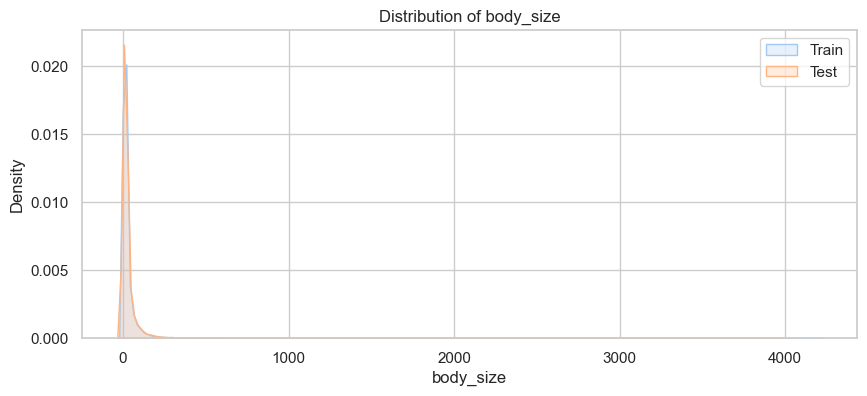

/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2563641917.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[col], label='Train', shade=True)
/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2563641917.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df[col], label='Test', shade=True)


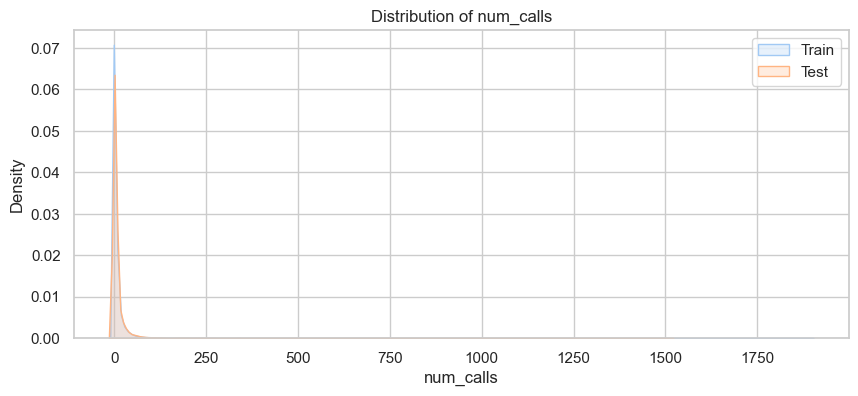

/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2563641917.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[col], label='Train', shade=True)
/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2563641917.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df[col], label='Test', shade=True)


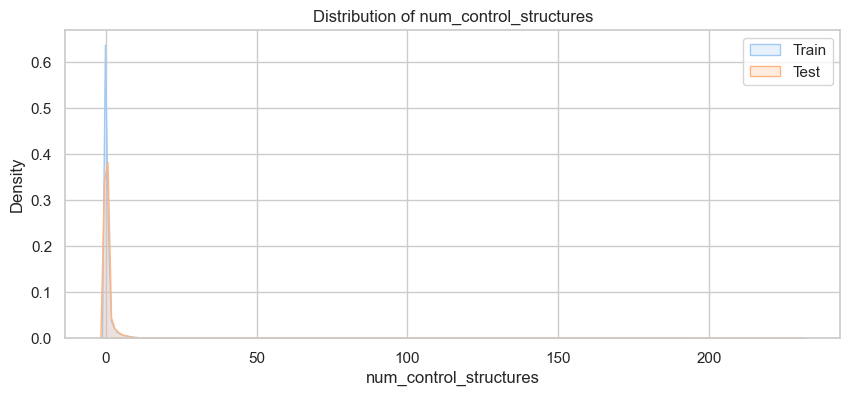

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['body_size', 'num_calls', 'num_control_structures']:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(train_df[col], label='Train', shade=True)
    sns.kdeplot(test_df[col], label='Test', shade=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()


#### My Goalis to Suggest Extract Method Refactors
- This means i,am trying to detect complex or bloated methods that could be split into smaller, more manageable ones.

- To do that, your model should learn patterns of methods that:

- Are long or dense

- Have many responsibilities (high number of control structures, calls, locals, etc.)

- Possibly violate the Single Responsibility Principle

- Exhibit signs of low cohesion or high cyclomatic complexity

## Top Features to Focus On

These will be the most relevant features in your dataset for this goal:

| Feature                  | Why It Matters                                                                 |
|--------------------------|--------------------------------------------------------------------------------|
| `body_size`              | Bigger body → higher chance of needing refactoring                            |
| `num_control_structures`| Too many if/loops/switches suggest logic complexity                            |
| `num_calls`              | High call volume = method doing too much                                      |
| `num_locals`             | Large number of locals → low abstraction, high complexity                     |
| `num_returns`            | Multiple return points often mean different concerns handled                  |
| `num_invocations`        | Repeated use may suggest this method is doing a lot                           |
| `line_number`            | Position in file may be weakly relevant (can be dropped unless correlated)    |
| `num_params`             | Too many params could suggest a method that is too generic or overloaded      |


we can ignore:

method_name, full_name → non-numeric, not helpful unless used for NLP

unique, top, freq → these are just metadata from describe()

### Applying Logistic Regression with Custom train_df and test_df

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Feature and target columns
feature_columns = [
    'num_params', 'line_number', 'num_calls', 'num_locals', 'num_returns',
    'num_invocations', 'body_size', 'num_control_structures', 'complexity_score',
    'calls_per_loc', 'control_density', 'returns_per_loc', 'locals_per_param'
]
target_column = 'complexity_bin'

# Define X and y for train/test
X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred = log_reg.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # or 'macro' / 'micro'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Results
print(f"🔍 Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"🏅 F1 Score:  {f1:.4f}")

print("\n📋 Detailed Classification Report:\n")
print(classification_report(y_test, y_pred))


🔍 Accuracy:  0.9996
🎯 Precision: 0.9996
📈 Recall:    0.9996
🏅 F1 Score:  0.9996

📋 Detailed Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4776
           1       1.00      1.00      1.00      1934
           2       1.00      1.00      1.00      1689

    accuracy                           1.00      8399
   macro avg       1.00      1.00      1.00      8399
weighted avg       1.00      1.00      1.00      8399



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


##### Define the Label Logic

Thsi score is too perfect. It is as if I am not really learning to predict a real-world extraction need . I,m learning to mimic the logic used to assign complexity_bin.

In [71]:
def needs_extraction(row):
    return (
        row['body_size'] > 50 or
        row['num_control_structures'] > 5 or
        row['num_locals'] > 10 or
        row['num_params'] > 5 or
        row['complexity_score'] > 0.75
    )


In [72]:
train_df['refactor_suggestion'] = train_df.apply(needs_extraction, axis=1).astype(int)
test_df['refactor_suggestion'] = test_df.apply(needs_extraction, axis=1).astype(int)


/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2884477310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['refactor_suggestion'] = train_df.apply(needs_extraction, axis=1).astype(int)
/var/folders/4b/_mj4qjj14rg6cxv5mbsj_j3c0000gn/T/ipykernel_22904/2884477310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['refactor_suggestion'] = test_df.apply(needs_extraction, axis=1).astype(int)


In [73]:
# Feature columns without complexity_score
feature_columns = [
    'num_params', 'line_number', 'num_calls', 'num_locals', 'num_returns',
    'num_invocations', 'body_size', 'num_control_structures',
    'calls_per_loc', 'control_density', 'returns_per_loc', 'locals_per_param'
]

# Filter out features that actually exist in both dataframes
available_features = list(set(feature_columns) & set(train_df.columns))
X_train = train_df[available_features]
X_test = test_df[available_features]

y_train = train_df['refactor_suggestion']
y_test = test_df['refactor_suggestion']


In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Train
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred = log_reg.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Report
print(f"🔍 Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📈 Recall:    {recall:.4f}")
print(f"🏅 F1 Score:  {f1:.4f}")
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))


🔍 Accuracy:  0.9964
🎯 Precision: 1.0000
📈 Recall:    0.9919
🏅 F1 Score:  0.9959

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4700
           1       1.00      0.99      1.00      3699

    accuracy                           1.00      8399
   macro avg       1.00      1.00      1.00      8399
weighted avg       1.00      1.00      1.00      8399



Damn the model is highly reliable in detecting when a method should be refactored via Extract Method, based on the custom rule you created.

##### Why Is It Doing So Well?  
The features (like body_size, num_control_structures, etc.) are very predictive of the refactor label  
The label logic (based on thresholds) is clear-cut, so the model learns the pattern easily  
It’s a binary classification task, and you have good class balance.  

I would not really know how real these predictions are, I will still apply differnt methods even thought this turned out to be a pretty good result. 